In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

## Задание 1

In [2]:
df = pd.read_csv('4_iris/iris.data.txt', header=None)
df.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

In [3]:
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


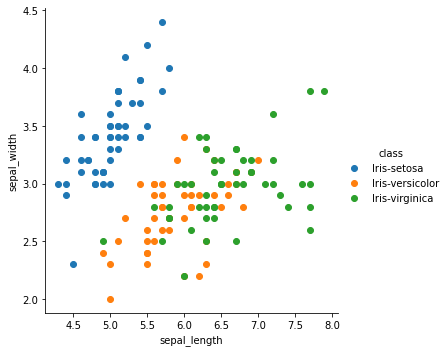

In [4]:
sns.FacetGrid(df, hue='class', height=5) \
.map(plt.scatter, 'sepal_length', 'sepal_width') \
.add_legend()
plt.show()

Как видно, один класс явно отделяется от остальных, а Versicolor и Vurginica накладываются друг на друга

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [6]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


В предоставленном наборе данных нет пропусков.  
Среди признаков в наборе данных имеются 4 признака с вещественными значениями, обозначающими длину и ширину чашелистика и лепестка. Также в данных есть признак-таргет, названный class, обозначающий, к какому классу относится цветок.

## Задание 2

In [7]:
df[df.duplicated(keep=False)]

,sepal_length,sepal_width,petal_length,petal_width,class
9,4.9,3.1,1.5,0.1,Iris-setosa
34,4.9,3.1,1.5,0.1,Iris-setosa
37,4.9,3.1,1.5,0.1,Iris-setosa
101,5.8,2.7,5.1,1.9,Iris-virginica
142,5.8,2.7,5.1,1.9,Iris-virginica


как видно, в наборе данных имеются 2 строки, которые имеют дупликаты

##### Размер до:

In [8]:
df.shape

(150, 5)

In [9]:
df = df[~df.duplicated()]

##### Размер после:

In [10]:
df.shape

(147, 5)

## Задание 3

<AxesSubplot:xlabel='class', ylabel='Count'>

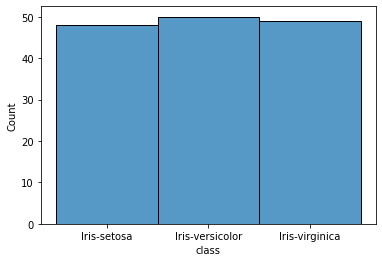

In [11]:
sns.histplot(data=df, x='class')

После удаления дупликатов, в классах Iris-setosa и Iris-virginica стало меньше 50 сэмплов, тем не менее, можно сказать, что данные имеют равномерное распределение по классам.  
Следовательно, в качестве метрики оценивания можно использовать ROC_AUC  

## Задание 4

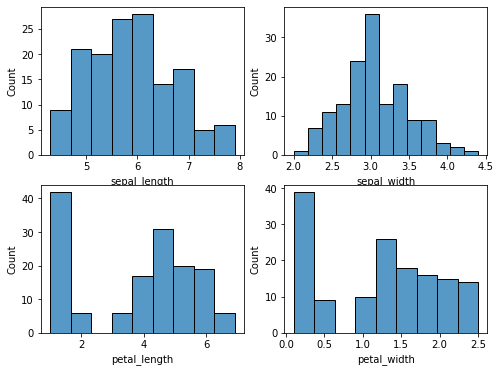

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
for i in range(4):
    sns.histplot(data=df, x=df.columns[i], ax=ax[int(i / 2), int(i % 2)])

Так как данные не имеют нормального распределения, в качестве способа масштабирования будет использована нормализация

<AxesSubplot:>

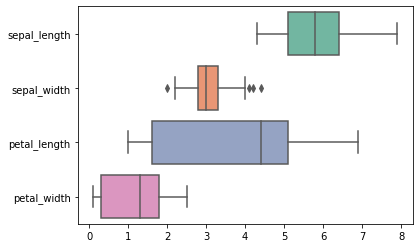

In [13]:
sns.boxplot(data=df, orient="h", palette="Set2")

In [14]:
df_norm = df.copy()

In [15]:
df_norm.iloc[:, :4] = MinMaxScaler().fit_transform(df.iloc[:, :4])

In [16]:
df_norm.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,0.222222,0.625000,0.067797,0.041667,Iris-setosa
1,0.166667,0.416667,0.067797,0.041667,Iris-setosa
2,0.111111,0.500000,0.050847,0.041667,Iris-setosa
3,0.083333,0.458333,0.084746,0.041667,Iris-setosa
4,0.194444,0.666667,0.067797,0.041667,Iris-setosa


<AxesSubplot:>

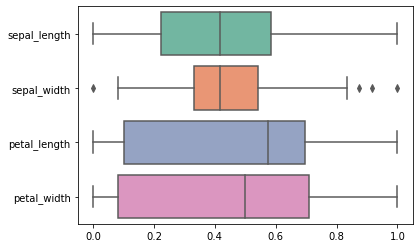

In [17]:
sns.boxplot(data=df_norm, orient="h", palette="Set2")

## Задание 5

Так как из категориальных признаков в этом наборе данных есть только тагрет, то его соответственно нет смысла преобразовывать с помощью OHE, необходимо, чтоб остался один столбец с классами, но они просто имели числовые значения, для возможности работы с рекоммендерами. Так что единственный логичный вариант в данном случае - LabelEncoder

In [18]:
class_map = {name: i for i, name in enumerate(df_norm['class'].unique())}
class_map

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [19]:
df_norm['class'] = df_norm['class'].map(class_map)

In [20]:
df_norm.sample(n=5, random_state=2)

,sepal_length,sepal_width,petal_length,petal_width,class
93,0.194444,0.125000,0.389831,0.375000,1
129,0.805556,0.416667,0.813559,0.625000,2
3,0.083333,0.458333,0.084746,0.041667,0
36,0.333333,0.625000,0.050847,0.041667,0
136,0.555556,0.583333,0.779661,0.958333,2


## Задание 6

<AxesSubplot:>

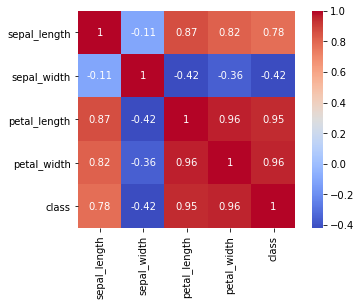

In [21]:
sns.heatmap(df_norm.corr(), annot=True, square=True, cmap=plt.cm.coolwarm)

Как видно, наиболее сильно таргет коррелирует с признаками, характеризующими лепесток.  
Так же они сильно коррелируют друг с другом

## Задание 7

In [22]:
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
class           0
dtype: int64

В данных нет пропущенных значений

## Задание 8

Можно перемешать классы, чтоб они не шли по-порядку. так разбиение на трейн и тест и обучение моделей будет честнее

In [23]:
df_norm = df_norm.sample(frac=1, random_state=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_norm.drop(columns=['petal_length', 'class']), 
                                                    df_norm.iloc[:, -1], stratify=df_norm.iloc[:, -1], 
                                                    test_size=0.33, random_state=17)

In [25]:
X_train_tree, X_test_tree, y_train, y_test = train_test_split(df_norm.iloc[:, :4], df_norm.iloc[:, -1], 
                                                              stratify=df_norm.iloc[:, -1], 
                                                                        test_size=0.33, random_state=17)

In [26]:
y_train.value_counts()

2    33
1    33
0    32
Name: class, dtype: int64

In [27]:
y_test.value_counts()

1    17
2    16
0    16
Name: class, dtype: int64

In [28]:
ohe = OneHotEncoder()
y_test = ohe.fit_transform(y_test.values.reshape(-1, 1)).toarray()

In [29]:
rev_class_map = {v:i for i, v in class_map.items()}

In [30]:
def plot_roc_auc(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

    # Then np.interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 3

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))
    #plt.figure()
    ax[0].plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    ax[0].plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             linewidth=2)

    for i in range(3):
        ax[1].plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(rev_class_map[i], roc_auc[i]))

    ax[0].plot([0, 1], [0, 1], 'k--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Micro and macro averaging metrics ROC curves')
    ax[0].legend(loc="lower right")

    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC curves for each class')
    ax[1].legend(loc="lower right")
    plt.show()

In [31]:
def plot_pr(y_test, y_score):
    precision = dict()
    recall = dict()
    AP = dict()
    for i in range(3):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        AP[i] = average_precision_score(y_test[:, i], y_score[:, i])

    # Compute micro-average PR curve and PR area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    AP["micro"] = average_precision_score(y_test.ravel(), y_score.ravel())

    ##############################################################################
    # Plot PR curves for the multiclass problem

    # Compute macro-average PR curve and PR area

    # First aggregate all false positive rates
    all_precision = np.unique(np.concatenate([precision[i] for i in range(3)]))

    # Then np.interpolate all PR curves at this points
    mean_recall = np.zeros_like(all_precision)
    for i in range(3):
        mean_recall += np.interp(all_precision, precision[i], recall[i])

    # Finally average it and compute AUC
    mean_recall /= 3

    precision["macro"] = all_precision
    recall["macro"] = mean_recall
    AP["macro"] = average_precision_score(y_test, y_score)

    # Plot all PR curves
    fig, ax = plt.subplots(2, 1, figsize=(10, 12))
    #plt.figure()
    ax[0].plot(recall["micro"], precision["micro"],
             label='micro-average PR curve (AP = {0:0.2f})'
                   ''.format(AP["micro"]),
             linewidth=2)

    ax[0].plot(recall["macro"], precision["macro"],
             label='macro-average PR curve (AP = {0:0.2f})'
                   ''.format(AP["macro"]),
             linewidth=2)

    for i in range(3):
        ax[1].plot(recall[i], precision[i], label='PR curve of class {0} (AP = {1:0.2f})'
                                       ''.format(rev_class_map[i], AP[i]))

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('recall')
    ax[0].set_ylabel('precision')
    ax[0].set_title('Micro and macro averaging metrics PR curves')
    ax[0].legend(loc="lower right")

    ax[1].set_xlim([0.0, 1.00])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('recall')
    ax[1].set_ylabel('precision')
    ax[1].set_title('PR curves for each class')
    ax[1].legend(loc="lower right")
    plt.show()

### KNN

По умолчанию для мультиклассовой классификации в KNN используется One vs All подоход

In [32]:
knn_params = {
    'n_neighbors': list(range(5, 31, 5)),
    'p': list(range(1, 4)),
    'weights': ['uniform', 'distance'],
}
knn = KNeighborsClassifier()

так как в качестве метрики выбран roc auc, следовательно, невозможно получить эту метрику используя One vs One подход

In [33]:
grid_knn = GridSearchCV(knn, cv=5, param_grid=knn_params, scoring='roc_auc_ovr')

In [34]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 10, 15, 20, 25, 30], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc_ovr')

In [35]:
grid_knn.best_estimator_

KNeighborsClassifier(weights='distance')

In [36]:
y_score_knn=ohe.transform(grid_knn.best_estimator_.predict(X_test).reshape(-1, 1)).toarray()

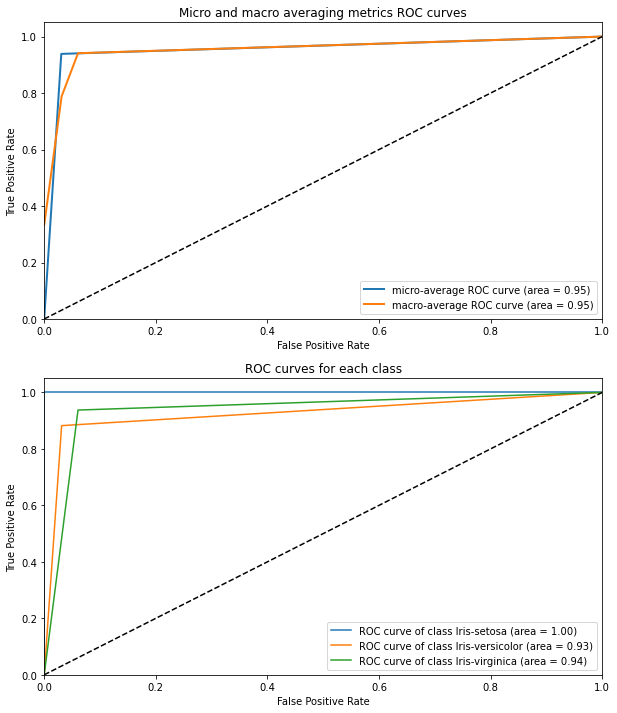

In [37]:
plot_roc_auc(y_test, y_score_knn)

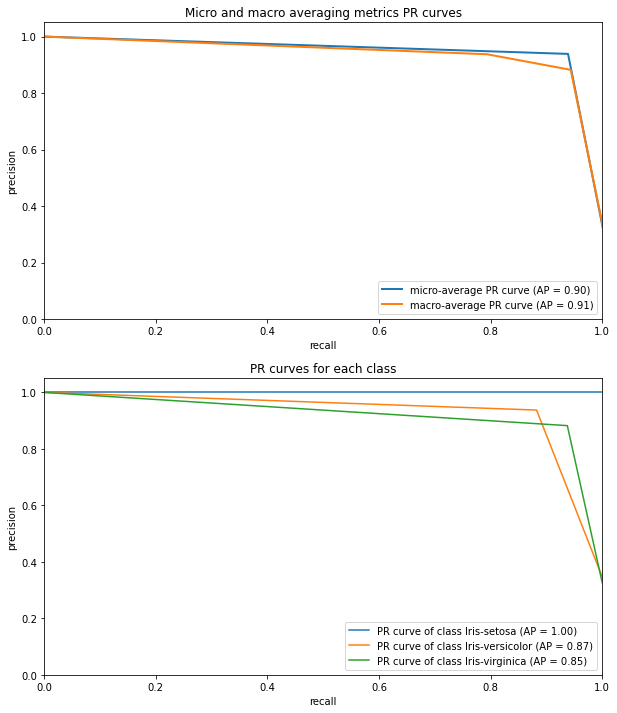

In [38]:
plot_pr(y_test, y_score_knn)

Как было замечено ранее, класс setosa отлично отделяется от других, когда оставшиеся 2 накладываются друг на друга

### DecisionTree

По умолчанию для мультиклассовой классификации в дереве решений используется One vs All подоход

In [39]:
tree_params = {
    'max_depth': list(range(3, 8, 2)),
    'min_samples_leaf': list(range(1, 6)),
    'criterion': ['gini', 'entropy'],
}
tree = DecisionTreeClassifier()

In [40]:
grid_tree = GridSearchCV(tree, cv=5, param_grid=tree_params, scoring='roc_auc_ovr')

In [41]:
grid_tree.fit(X_train_tree, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7],
                         'min_samples_leaf': [1, 2, 3, 4, 5]},
             scoring='roc_auc_ovr')

In [42]:
grid_tree.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=4)

In [43]:
y_score_tree = ohe.transform(grid_tree.best_estimator_.predict(X_test_tree).reshape(-1, 1)).toarray()

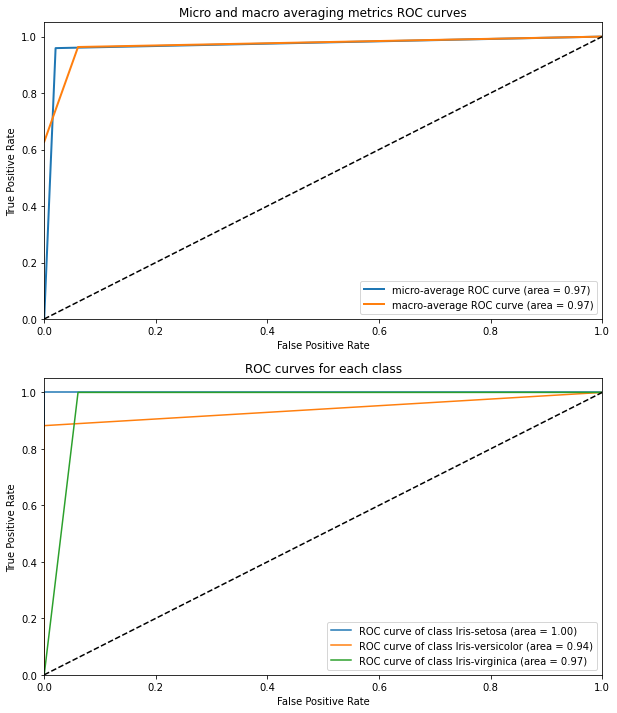

In [44]:
plot_roc_auc(y_test, y_score_tree)

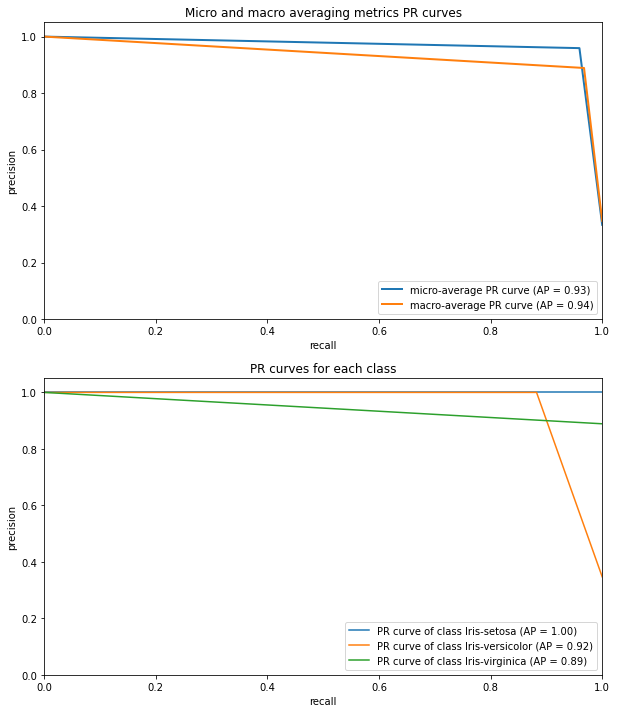

In [45]:
plot_pr(y_test, y_score_tree)

## Вывод

Таким образом, дерево решений показало результат лучше, чем k ближайших соседей